# Model13

In [1]:
import os

data_dir = 'data/'
fname = os.path.join(data_dir, 'dataset_rev4_train_RNN_rev1.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"datetime"', '"I"', '"T"', '"UV"', '"WS"', '"RH"', '"P"']
131587


In [2]:
import numpy as np
float_data = np.zeros((len(lines), len(header) - 1))

In [3]:
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

ValueError: cannot copy sequence with size 0 to array axis with dimension 6

In [4]:
float_data[131585, :]

array([43.  , 31.3 ,  0.1 , 15.1 , 53.8 ,  0.12])

In [5]:
float_data = float_data[:-1, :]

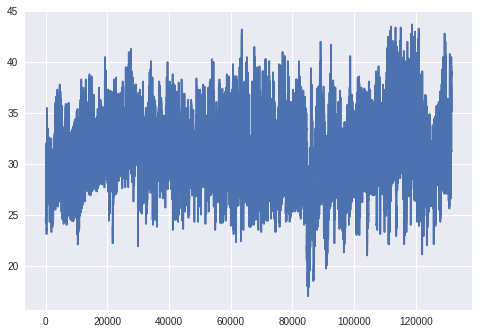

In [6]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

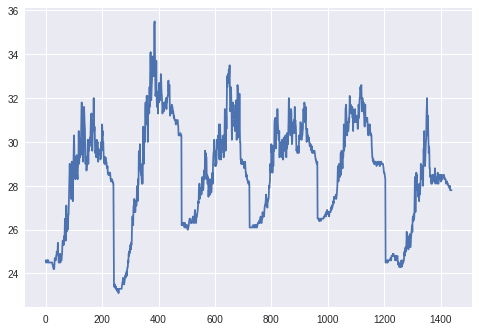

In [7]:
plt.plot(range(1440), temp[:1440])
plt.show()

In [8]:
mean = float_data[:60000].mean(axis=0)
float_data -= mean
std = float_data[:60000].std(axis=0)
float_data /= std

In [9]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [10]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=60000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=60001,
                    max_index=90000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=90001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (90000 - 60001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 90001 - lookback) // batch_size

In [11]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

1.480070529874667


In [12]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Using TensorFlow backend.


Epoch 1/20
500/500 [==============================] - 9s 18ms/step - loss: 0.6209 - val_loss: 0.7879
Epoch 2/20
500/500 [==============================] - 7s 15ms/step - loss: 0.3898 - val_loss: 0.9159
Epoch 3/20
500/500 [==============================] - 7s 14ms/step - loss: 0.3448 - val_loss: 0.8267
Epoch 4/20
500/500 [==============================] - 8s 15ms/step - loss: 0.3201 - val_loss: 0.8560
Epoch 5/20
500/500 [==============================] - 7s 15ms/step - loss: 0.3028 - val_loss: 0.8151
Epoch 6/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2879 - val_loss: 0.8778
Epoch 7/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2776 - val_loss: 0.8396
Epoch 8/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2696 - val_loss: 0.8557
Epoch 9/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2605 - val_loss: 0.8449
Epoch 10/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2546 - val_l

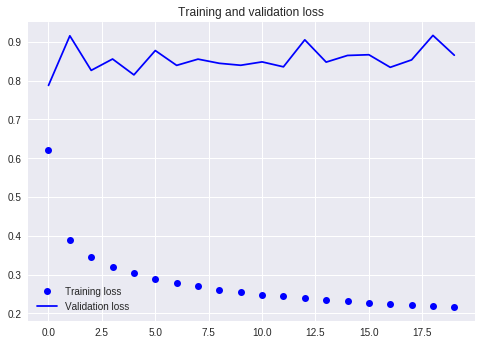

In [14]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 95s 190ms/step - loss: 0.5118 - val_loss: 0.7254
Epoch 2/20
500/500 [==============================] - 88s 176ms/step - loss: 0.4488 - val_loss: 0.7377
Epoch 3/20
500/500 [==============================] - 94s 188ms/step - loss: 0.4375 - val_loss: 0.7453
Epoch 4/20
500/500 [==============================] - 89s 177ms/step - loss: 0.4264 - val_loss: 0.7392
Epoch 5/20
500/500 [==============================] - 95s 190ms/step - loss: 0.4150 - val_loss: 0.7488
Epoch 6/20
500/500 [==============================] - 89s 178ms/step - loss: 0.4056 - val_loss: 0.7976
Epoch 7/20
500/500 [==============================] - 94s 188ms/step - loss: 0.3975 - val_loss: 0.7943
Epoch 8/20
500/500 [==============================] - 90s 179ms/step - loss: 0.3893 - val_loss: 0.8004
Epoch 9/20
500/500 [==============================] - 93s 187ms/step - loss: 0.3839 - val_loss: 0.8141
Epoch 10/20
500/500 [==============================] - 89s 178ms/step - l

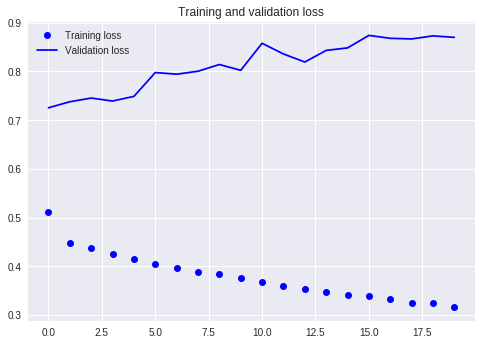

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 104s 208ms/step - loss: 0.5824 - val_loss: 0.7784
Epoch 2/40
500/500 [==============================] - 107s 215ms/step - loss: 0.5242 - val_loss: 0.7614
Epoch 3/40
500/500 [==============================] - 108s 216ms/step - loss: 0.4970 - val_loss: 0.7491
Epoch 4/40
500/500 [==============================] - 108s 217ms/step - loss: 0.4860 - val_loss: 0.7235
Epoch 5/40
500/500 [==============================] - 107s 214ms/step - loss: 0.4770 - val_loss: 0.7516
Epoch 6/40
500/500 [==============================] - 106s 212ms/step - loss: 0.4736 - val_loss: 0.7641
Epoch 7/40
500/500 [==============================] - 108s 216ms/step - loss: 0.4650 - val_loss: 0.7194
Epoch 8/40
500/500 [==============================] - 108s 216ms/step - loss: 0.4625 - val_loss: 0.7499
Epoch 9/40
500/500 [==============================] - 109s 218ms/step - loss: 0.4606 - val_loss: 0.7281
Epoch 10/40
500/500 [==============================] - 104s 207m

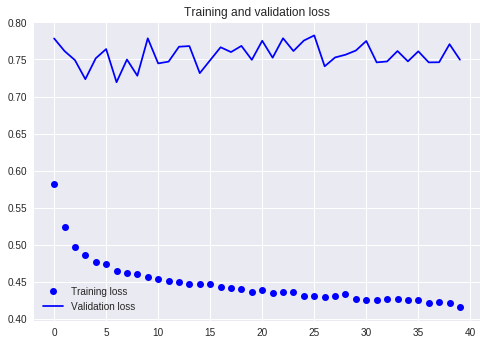

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 313s 626ms/step - loss: 0.5662 - val_loss: 0.7748
Epoch 2/40
500/500 [==============================] - 316s 633ms/step - loss: 0.5125 - val_loss: 0.7892
Epoch 3/40
500/500 [==============================] - 314s 628ms/step - loss: 0.4953 - val_loss: 0.7799
Epoch 4/40
500/500 [==============================] - 313s 626ms/step - loss: 0.4830 - val_loss: 0.7713
Epoch 5/40
500/500 [==============================] - 313s 627ms/step - loss: 0.4745 - val_loss: 0.7701
Epoch 6/40
500/500 [==============================] - 315s 631ms/step - loss: 0.4665 - val_loss: 0.7981
Epoch 7/40
500/500 [==============================] - 319s 637ms/step - loss: 0.4592 - val_loss: 0.7713
Epoch 8/40
500/500 [==============================] - 312s 624ms/step - loss: 0.4540 - val_loss: 0.7570
Epoch 9/40
500/500 [==============================] - 311s 623ms/step - loss: 0.4496 - val_loss: 0.7617
Epoch 10/40
500/500 [==============================] - 310s 620m

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()